# Arabidopsis Multi-Plant Tutorial

This is a fully-functioning workflow that demonstrates how to analyze the shape, size, and color of individual arabidopsis plants grown in a tray. Similar methods will work for other plant species imaged in this layout until the plants grow large enough to obscure each other.


In [22]:
# Install PlantCV and required dependencies
%pip install "altair>=5" ipympl plantcv

# Give access and mount your Google Drive (need a Google Account)
# Change path to directory you wish output files to be saved to.
from google.colab import drive
drive.mount('/content/gdrive')

# Enable widget feature with matplotlib
from google.colab import output
output.enable_custom_widget_manager()

#View working directory, may need to change path
%pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content'

In [23]:
# Set the notebook display method
%matplotlib inline

# Section 1: Importing Image and Libraries

In [24]:
# Import libraries
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs
pcv.__version__

'4.8'

## Input/Ouput variables

Using this while developing a workflow in Jupyter makes it easier to convert the workflow to a script later.

In [25]:
# Input/output options
args = WorkflowInputs(
    images=["arabidopsis_tray.jpg"],
    names="image1",
    result="arabidopsis_results.json",
    outdir=".",
    writeimg=True,
    debug="plot",
    sample_label="genotype"
    )

In [26]:
# Set debug to the global parameter
pcv.params.debug = args.debug

# Set plotting size (default = 100)
pcv.params.dpi = 100

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 10
pcv.params.text_thickness = 20

## Read the input image

### Google Colaboratory Users:
If you are running this notebook using Google Colaboratory, you will need to use the cell below to complete the tutorial unless you cloned the repository from GitHub to your personal Google Drive account. Once you begin developing your workflow for your data, you can delete this text cell and the code cell below so you avoid any conflicts the next time you use this notebook.

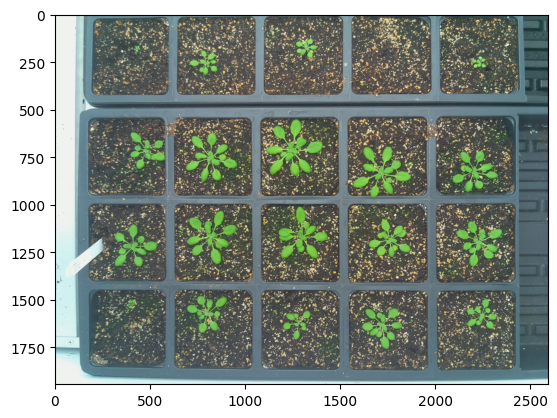

In [27]:
img = pcv.io.open_url(url="https://raw.githubusercontent.com/danforthcenter/plantcv-tutorial-arabidopsis-tray/main/img/arabidopsis_tray.jpg")

### Local system use:
If you have downloaded this notebook or the repository to your local device, then you will need to use the cell below to bring your image into the notebook. Do not run this line if you are navigating through the **tutorial** using Google Colaboratory.

NOTE: *If you are developing your own workflow using this notebook, make sure you remove the code cell above with the URL and uncomment (remove the hashtag [#] to make the code active. This will call the image you defined during the Inputs/Outputs step.*

### Reading images into your environment using *pcv.readimage()*
Inputs:
   * filename = Image file to be read in
   * mode     = How the image will be read into the notebook; either 'native' (default), 'rgb', 'gray', 'csv', or 'envi'

In [28]:
# img, path, filename = pcv.readimage(filename=args.image1)

# Section 2: Segmenting plant from background and identifying plant object(s)


## Visualize colorspaces

The visualization tool converts the color image into HSV and LAB colorspaces
and displays the grayscale channels in a matrix so that they can be
visualized simultaneously. The idea is to select a channel that maximizes
the difference between the plant and the background pixels.

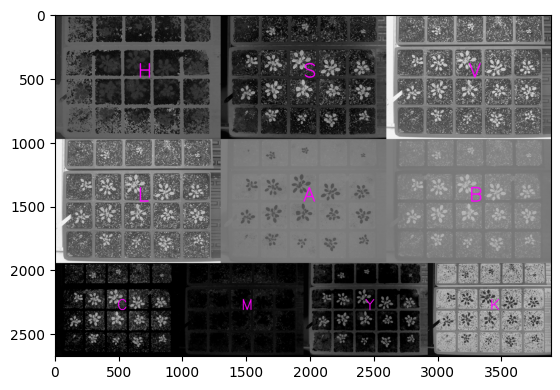

In [29]:
# Inputs:
#   rbg_img = original image
#   original_img = whether to includ the RGB image in the display:
#                  True (default) or False
colorspaces = pcv.visualize.colorspaces(rgb_img=img, original_img=False)

## Convert the color image to grayscale

Converts the input color image into the LAB colorspace
and returns the A (green-magenta) channel as a grayscale
image.

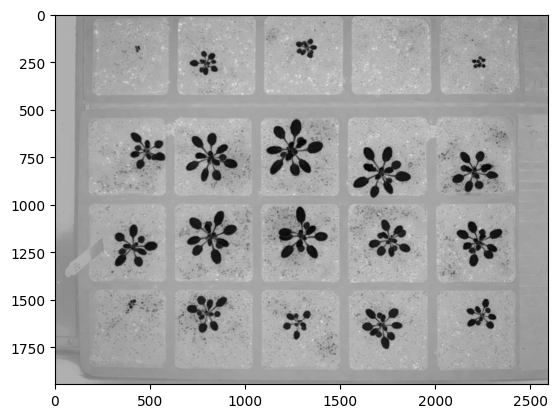

In [30]:
# Inputs:
#   rbg_img = original image
#   channel = desired colorspace ('l', 'a', or 'b')
a = pcv.rgb2gray_lab(rgb_img=img, channel='a')

## Visualize the distribution of grayscale values

A histogram can be used to visualize the distribution of values
in an image. The histogram can aid in the selection of a
threshold value. This is NOT helpful in parallel, only while building a workflow.

For this image, the large peak between 100-140 are from the
brighter background pixels. The smaller peak between 80-90
are the darker plant pixels.

In [31]:
hist = pcv.visualize.histogram(img=a, bins=25)

alt.Chart(...)

## Threshold the grayscale image

Use a threshold function (binary in this case) to segment the grayscale
image into plant (white) and background (black) pixels. Using the
histogram above, a threshold point between 90-110 will segment the
plant and background peaks. Because the plants are the darker pixels
in this image, use `object_type="dark"` to do an inverse threshold.

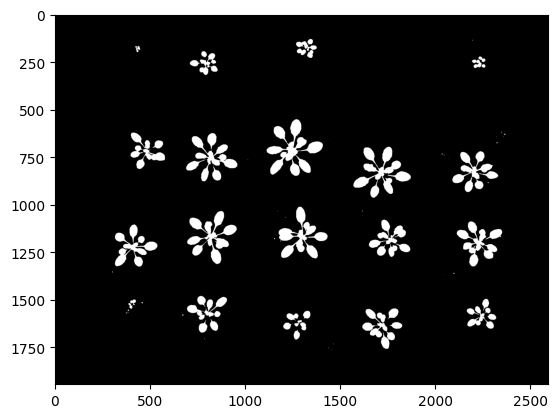

In [32]:
a_thresh = pcv.threshold.binary(gray_img=a, threshold=100, object_type='dark')

## Remove small background noise

Thresholding mostly labeled plant pixels white but also labeled
small regions of the background white. The fill function removes
"salt" noise from the background by filtering white regions by size.

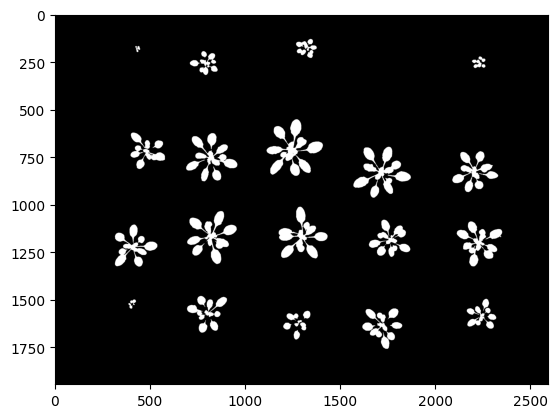

In [33]:
a_fill = pcv.fill(bin_img=a_thresh, size=200)

# Section 3: Define a region of interest for each plant

Use the automatic grid detection tool to define a region of interest (ROI) for each pot
in the tray. Each ROI will be associated with a plant later. The ROIs
do not need to completely contain a whole plant but must only overlap a
single plant each.

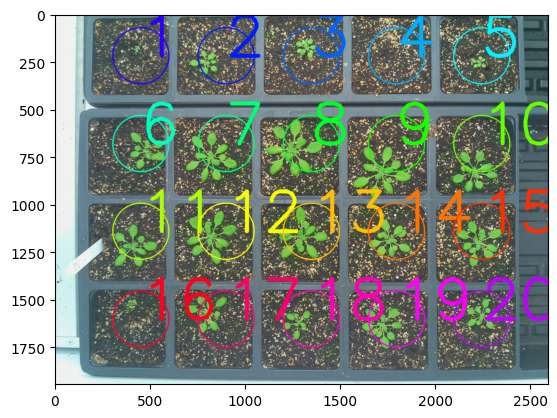

In [34]:
rois = pcv.roi.auto_grid(mask=a_fill, nrows=4, ncols=5, img=img)

# Section 4: Create a labeled mask
In order to measure each plant separately, rather than as one object of disconnected blobs, we must create a labeled masked where each plant has a specific pixel value even in the case of disconnected leaves in the binary mask.



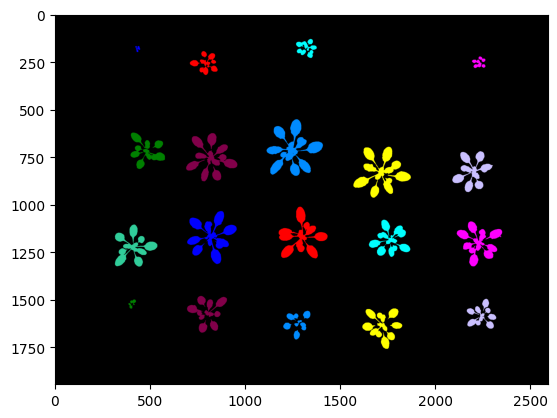

In [35]:
# Create a labeled mask, this function works very similarly to the roi.filter step above
labeled_mask, num_plants = pcv.create_labels(mask=a_fill, rois=rois, roi_type="partial")


# Section 5: Measure each plant


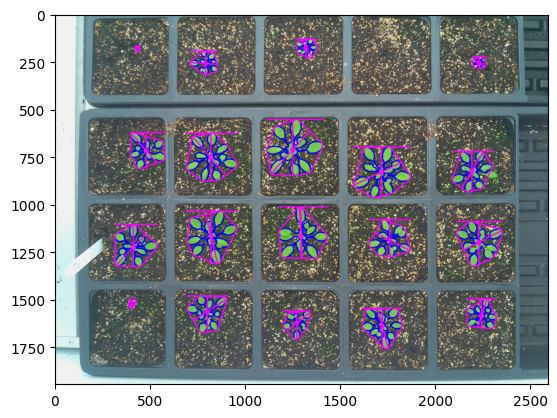

In [36]:
shape_img = pcv.analyze.size(img=img, labeled_mask=labeled_mask, n_labels=20)

In [37]:
shape_img = pcv.analyze.color(rgb_img=img, labeled_mask=labeled_mask, n_labels=20, colorspaces="HSV")

alt.FacetChart(...)

## Save the results

During analysis, measurements are stored in the background in the `outputs` class.

This example includes image analysis for 'area', 'convex_hull_area', 'solidity', 'perimeter', 'width', 'height', 'longest_path', 'center_of_mass, 'convex_hull_vertices', 'object_in_frame', 'ellipse_center', 'ellipse_major_axis', 'ellipse_minor_axis', 'ellipse_angle', 'ellipse_eccentricity' while using `pcv.analyze.size`. Plus we have color trait information also!


In [38]:
pcv.outputs.save_results(filename=args.result, outformat="json")